In [28]:
%pip uninstall -qqqy google-generativeai google-ai-generativelanguage
%pip install -qU "langchain[google-genai]" langchain langgraph>0.2.27 langchain_community pypdf faiss-cpu langchain-tavily langchain-huggingface langgraph-checkpoint-sqlite tiktoken langchain-neo4j neo4j
import os
import getpass
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
load_dotenv()
# .env should also have TAVILY_API_KEY
os.environ["USER_AGENT"] = "MyLangChainBot/1.0 (+https://example.com/contact)"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "default"
if not os.environ.get("TAVILY_API_KEY"):
  os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter API key for Tavily: ")
if not os.environ.get("HF_TOKEN"):
  os.environ["HF_TOKEN"] = getpass.getpass("Enter API key for Hugging Face: ")
if not os.environ.get("GEMINI_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")
else:
  os.environ["GOOGLE_API_KEY"] = os.environ.get("GEMINI_API_KEY")
model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

--2025-09-01 11:19:17--  https://github.com/neo4j-contrib/neo4j-apoc-procedures/releases
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/var/lib/neo4j/plugins/releases’

releases                [ <=>                ] 438.93K  --.-KB/s    in 0.07s   

2025-09-01 11:19:18 (6.57 MB/s) - ‘/var/lib/neo4j/plugins/releases’ saved [449461]



In [22]:
# Neo4j whole setup for Google Colab
!wget -O - https://debian.neo4j.com/neotechnology.gpg.key | apt-key add -
!echo 'deb https://debian.neo4j.com stable 4.4' > /etc/apt/sources.list.d/neo4j.list
!apt-get update
!apt-get install -y neo4j

# Stop Neo4j and set initial password
!neo4j stop
!neo4j-admin set-initial-password newpassword

# Download APOC (using a version that exists)
!wget -q https://github.com/neo4j-contrib/neo4j-apoc-procedures/releases/download/4.4.0.19/apoc-4.4.0.19-all.jar -P /var/lib/neo4j/plugins/
!chown neo4j:neo4j /var/lib/neo4j/plugins/apoc-4.4.0.19-all.jar

# Configure Neo4j
!echo "dbms.security.procedures.unrestricted=apoc.*" >> /etc/neo4j/neo4j.conf
!echo "dbms.security.procedures.allowlist=apoc.*" >> /etc/neo4j/neo4j.conf
!sed -i 's/^#\?dbms.connector.bolt.enabled=.*/dbms.connector.bolt.enabled=true/' /etc/neo4j/neo4j.conf
!sed -i 's/^#\?dbms.connector.bolt.listen_address=.*/dbms.connector.bolt.listen_address=0.0.0.0:7687/' /etc/neo4j/neo4j.conf
!sed -i 's/^#\?dbms.connector.http.listen_address=.*/dbms.connector.http.listen_address=0.0.0.0:7474/' /etc/neo4j/neo4j.conf

# Start Neo4j
!neo4j start

# Wait for Neo4j to start and check status
!sleep 10
!neo4j status

# Check if Bolt port is listening
!ss -tlnp | grep 7687 || echo "Bolt port not listening yet, waiting..."
!sleep 5
!ss -tlnp | grep 7687 || echo "Still not listening, trying to restart..."
!neo4j restart
!sleep 10
!ss -tlnp | grep 7687

--2025-09-01 11:27:11--  https://debian.neo4j.com/neotechnology.gpg.key
Resolving debian.neo4j.com (debian.neo4j.com)... 13.249.98.9, 13.249.98.81, 13.249.98.108, ...
Connecting to debian.neo4j.com (debian.neo4j.com)|13.249.98.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3905 (3.8K) [application/pgp-keys]
Saving to: ‘STDOUT’

-                   100%[===================>]   3.81K  --.-KB/s    in 0s      

2025-09-01 11:27:11 (24.6 MB/s) - written to stdout [3905/3905]

OK
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://cli.github.com/packages stable InRelease
Hit:5 https://debian.neo4j.com stable InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:8 https://cloud.r-project.org/bin/linux/ubunt

In [30]:
from langchain_neo4j import Neo4jGraph
from neo4j import GraphDatabase

# Create Aura DB account for free and get these
aura_uri = getpass.getpass('Enter your AuraDB URI (e.g., neo4j+s://xxxxxxxx.databases.neo4j.io): ')
aura_user = getpass.getpass('Enter your username: ')
aura_password = getpass.getpass('Enter your password: ')

os.environ["NEO4J_URI"] = aura_uri
os.environ["NEO4J_USERNAME"] = aura_user
os.environ["NEO4J_PASSWORD"] = aura_password

driver = GraphDatabase.driver(aura_uri, auth=(aura_user, aura_password))

bolt_uri = aura_uri.replace("neo4j+s://", "bolt+s://")

graph = Neo4jGraph(
    url=bolt_uri,
    username=aura_user,
    password=aura_password,
    enhanced_schema=True
)

# Import movie information

movies_query = """
LOAD CSV WITH HEADERS FROM
'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/movies/movies_small.csv'
AS row
MERGE (m:Movie {id:row.movieId})
SET m.released = date(row.released),
    m.title = row.title,
    m.imdbRating = toFloat(row.imdbRating)
FOREACH (director in split(row.director, '|') |
    MERGE (p:Person {name:trim(director)})
    MERGE (p)-[:DIRECTED]->(m))
FOREACH (actor in split(row.actors, '|') |
    MERGE (p:Person {name:trim(actor)})
    MERGE (p)-[:ACTED_IN]->(m))
FOREACH (genre in split(row.genres, '|') |
    MERGE (g:Genre {name:trim(genre)})
    MERGE (m)-[:IN_GENRE]->(g))
"""

graph.query(movies_query)

Enter your AuraDB URI (e.g., neo4j+s://xxxxxxxx.databases.neo4j.io): ··········
Enter your username: ··········
Enter your password: ··········


[]

In [31]:
graph.refresh_schema()
print(graph.schema)
enhanced_graph = Neo4jGraph(enhanced_schema=True)
print(enhanced_graph.schema)

Node properties:
- **Movie**
  - `id`: STRING Example: "1"
  - `released`: DATE Min: 1964-12-16, Max: 1996-09-15
  - `title`: STRING Example: "Toy Story"
  - `imdbRating`: FLOAT Min: 2.4, Max: 9.3
- **Person**
  - `name`: STRING Example: "John Lasseter"
- **Genre**
  - `name`: STRING Example: "Adventure"
Relationship properties:

The relationships:
(:Movie)-[:IN_GENRE]->(:Genre)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:ACTED_IN]->(:Movie)
Node properties:
- **Movie**
  - `id`: STRING Example: "1"
  - `released`: DATE Min: 1964-12-16, Max: 1996-09-15
  - `title`: STRING Example: "Toy Story"
  - `imdbRating`: FLOAT Min: 2.4, Max: 9.3
- **Person**
  - `name`: STRING Example: "John Lasseter"
- **Genre**
  - `name`: STRING Example: "Adventure"
Relationship properties:

The relationships:
(:Movie)-[:IN_GENRE]->(:Genre)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:ACTED_IN]->(:Movie)


In [32]:
from langchain_neo4j import GraphCypherQAChain
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_output_tokens=1024,
    timeout=None,
    max_retries=2,
)
chain = GraphCypherQAChain.from_llm(
    graph=enhanced_graph, llm=llm, verbose=True, allow_dangerous_requests=True
)
response = chain.invoke({"query": "What was the cast of the Casino?"})
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
WHERE m.title = "Casino"
RETURN p.name

Full Context:
[{'p.name': 'Robert De Niro'}, {'p.name': 'Joe Pesci'}, {'p.name': 'Sharon Stone'}, {'p.name': 'James Woods'}]

> Finished chain.


{'query': 'What was the cast of the Casino?',
 'result': 'Robert De Niro, Joe Pesci, Sharon Stone, James Woods was the cast of the Casino.'}

In [33]:
from operator import add
from typing import Annotated, List
from typing_extensions import TypedDict

class InputState(TypedDict):
    question: str

class OverallState(TypedDict):
    question: str
    next_action: str
    cypher_statement: str
    cypher_errors: List[str]
    database_records: List[dict]
    steps: Annotated[List[str], add]

class OutputState(TypedDict):
    answer: str
    steps: List[str]
    cypher_statement: str

In [34]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

guardrails_system = """
As an intelligent assistant, your primary objective is to decide whether a given question is related to movies or not.
If the question is related to movies, output "movie". Otherwise, output "end".
To make this decision, assess the content of the question and determine if it refers to any movie, actor, director, film industry,
or related topics. Provide only the specified output: "movie" or "end".
"""
guardrails_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            guardrails_system,
        ),
        (
            "human",
            ("{question}"),
        ),
    ]
)


class GuardrailsOutput(BaseModel):
    decision: Literal["movie", "end"] = Field(
        description="Decision on whether the question is related to movies"
    )


guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)


def guardrails(state: InputState) -> OverallState:
    """
    Decides if the question is related to movies or not.
    """
    guardrails_output = guardrails_chain.invoke({"question": state.get("question")})
    database_records = None
    if guardrails_output.decision == "end":
        database_records = "This questions is not about movies or their cast. Therefore I cannot answer this question."
    return {
        "next_action": guardrails_output.decision,
        "database_records": database_records,
        "steps": ["guardrail"],
    }

In [37]:
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_neo4j import Neo4jVector
from langchain_community.embeddings import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cpu'})

examples = [
    {
        "question": "How many artists are there?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie) RETURN count(DISTINCT a)",
    },
    {
        "question": "Which actors played in the movie Casino?",
        "query": "MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]-(a) RETURN a.name",
    },
    {
        "question": "How many movies has Tom Hanks acted in?",
        "query": "MATCH (a:Person {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie) RETURN count(m)",
    },
    {
        "question": "List all the genres of the movie Schindler's List",
        "query": "MATCH (m:Movie {title: 'Schindler's List'})-[:IN_GENRE]->(g:Genre) RETURN g.name",
    },
    {
        "question": "Which actors have worked in movies from both the comedy and action genres?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g1:Genre), (a)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g2:Genre) WHERE g1.name = 'Comedy' AND g2.name = 'Action' RETURN DISTINCT a.name",
    },
    {
        "question": "Which directors have made movies with at least three different actors named 'John'?",
        "query": "MATCH (d:Person)-[:DIRECTED]->(m:Movie)<-[:ACTED_IN]-(a:Person) WHERE a.name STARTS WITH 'John' WITH d, COUNT(DISTINCT a) AS JohnsCount WHERE JohnsCount >= 3 RETURN d.name",
    },
    {
        "question": "Identify movies where directors also played a role in the film.",
        "query": "MATCH (p:Person)-[:DIRECTED]->(m:Movie), (p)-[:ACTED_IN]->(m) RETURN m.title, p.name",
    },
    {
        "question": "Find the actor with the highest number of movies in the database.",
        "query": "MATCH (a:Actor)-[:ACTED_IN]->(m:Movie) RETURN a.name, COUNT(m) AS movieCount ORDER BY movieCount DESC LIMIT 1",
    },
]

example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples, HuggingFaceEmbeddings(), Neo4jVector, k=5, input_keys=["question"]
)

/tmp/ipython-input-1335643757.py:46: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  examples, HuggingFaceEmbeddings(), Neo4jVector, k=5, input_keys=["question"]


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [38]:
from langchain_core.output_parsers import StrOutputParser

text2cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "Given an input question, convert it to a Cypher query. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.
Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!
Here is the schema information
{schema}

Below are a number of examples of questions and their corresponding Cypher queries.

{fewshot_examples}

User input: {question}
Cypher query:"""
            ),
        ),
    ]
)

text2cypher_chain = text2cypher_prompt | llm | StrOutputParser()


def generate_cypher(state: OverallState) -> OverallState:
    """
    Generates a cypher statement based on the provided schema and user input
    """
    NL = "\n"
    fewshot_examples = (NL * 2).join(
        [
            f"Question: {el['question']}{NL}Cypher:{el['query']}"
            for el in example_selector.select_examples(
                {"question": state.get("question")}
            )
        ]
    )
    generated_cypher = text2cypher_chain.invoke(
        {
            "question": state.get("question"),
            "fewshot_examples": fewshot_examples,
            "schema": enhanced_graph.schema,
        }
    )
    return {"cypher_statement": generated_cypher, "steps": ["generate_cypher"]}

In [39]:
from typing import List, Optional

validate_cypher_system = """
You are a Cypher expert reviewing a statement written by a junior developer.
"""

validate_cypher_user = """You must check the following:
* Are there any syntax errors in the Cypher statement?
* Are there any missing or undefined variables in the Cypher statement?
* Are any node labels missing from the schema?
* Are any relationship types missing from the schema?
* Are any of the properties not included in the schema?
* Does the Cypher statement include enough information to answer the question?

Examples of good errors:
* Label (:Foo) does not exist, did you mean (:Bar)?
* Property bar does not exist for label Foo, did you mean baz?
* Relationship FOO does not exist, did you mean FOO_BAR?

Schema:
{schema}

The question is:
{question}

The Cypher statement is:
{cypher}

Make sure you don't make any mistakes!"""

validate_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            validate_cypher_system,
        ),
        (
            "human",
            (validate_cypher_user),
        ),
    ]
)


class Property(BaseModel):
    """
    Represents a filter condition based on a specific node property in a graph in a Cypher statement.
    """

    node_label: str = Field(
        description="The label of the node to which this property belongs."
    )
    property_key: str = Field(description="The key of the property being filtered.")
    property_value: str = Field(
        description="The value that the property is being matched against."
    )


class ValidateCypherOutput(BaseModel):
    """
    Represents the validation result of a Cypher query's output,
    including any errors and applied filters.
    """

    errors: Optional[List[str]] = Field(
        description="A list of syntax or semantical errors in the Cypher statement. Always explain the discrepancy between schema and Cypher statement"
    )
    filters: Optional[List[Property]] = Field(
        description="A list of property-based filters applied in the Cypher statement."
    )


validate_cypher_chain = validate_cypher_prompt | llm.with_structured_output(
    ValidateCypherOutput
)

In [40]:
from langchain_neo4j.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema

# Cypher query corrector is experimental
corrector_schema = [
    Schema(el["start"], el["type"], el["end"])
    for el in enhanced_graph.structured_schema.get("relationships")
]
cypher_query_corrector = CypherQueryCorrector(corrector_schema)

In [41]:
from neo4j.exceptions import CypherSyntaxError


def validate_cypher(state: OverallState) -> OverallState:
    """
    Validates the Cypher statements and maps any property values to the database.
    """
    errors = []
    mapping_errors = []
    # Check for syntax errors
    try:
        enhanced_graph.query(f"EXPLAIN {state.get('cypher_statement')}")
    except CypherSyntaxError as e:
        errors.append(e.message)
    # Experimental feature for correcting relationship directions
    corrected_cypher = cypher_query_corrector(state.get("cypher_statement"))
    if not corrected_cypher:
        errors.append("The generated Cypher statement doesn't fit the graph schema")
    if not corrected_cypher == state.get("cypher_statement"):
        print("Relationship direction was corrected")
    # Use LLM to find additional potential errors and get the mapping for values
    llm_output = validate_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "schema": enhanced_graph.schema,
            "cypher": state.get("cypher_statement"),
        }
    )
    if llm_output.errors:
        errors.extend(llm_output.errors)
    if llm_output.filters:
        for filter in llm_output.filters:
            # Do mapping only for string values
            if (
                not [
                    prop
                    for prop in enhanced_graph.structured_schema["node_props"][
                        filter.node_label
                    ]
                    if prop["property"] == filter.property_key
                ][0]["type"]
                == "STRING"
            ):
                continue
            mapping = enhanced_graph.query(
                f"MATCH (n:{filter.node_label}) WHERE toLower(n.`{filter.property_key}`) = toLower($value) RETURN 'yes' LIMIT 1",
                {"value": filter.property_value},
            )
            if not mapping:
                print(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
                mapping_errors.append(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
    if mapping_errors:
        next_action = "end"
    elif errors:
        next_action = "correct_cypher"
    else:
        next_action = "execute_cypher"

    return {
        "next_action": next_action,
        "cypher_statement": corrected_cypher,
        "cypher_errors": errors,
        "steps": ["validate_cypher"],
    }

In [42]:
correct_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are a Cypher expert reviewing a statement written by a junior developer. "
                "You need to correct the Cypher statement based on the provided errors. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """Check for invalid syntax or semantics and return a corrected Cypher statement.

Schema:
{schema}

Note: Do not include any explanations or apologies in your responses.
Do not wrap the response in any backticks or anything else.
Respond with a Cypher statement only!

Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.

The question is:
{question}

The Cypher statement is:
{cypher}

The errors are:
{errors}

Corrected Cypher statement: """
            ),
        ),
    ]
)

correct_cypher_chain = correct_cypher_prompt | llm | StrOutputParser()


def correct_cypher(state: OverallState) -> OverallState:
    """
    Correct the Cypher statement based on the provided errors.
    """
    corrected_cypher = correct_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "errors": state.get("cypher_errors"),
            "cypher": state.get("cypher_statement"),
            "schema": enhanced_graph.schema,
        }
    )

    return {
        "next_action": "validate_cypher",
        "cypher_statement": corrected_cypher,
        "steps": ["correct_cypher"],
    }

In [43]:
no_results = "I couldn't find any relevant information in the database"


def execute_cypher(state: OverallState) -> OverallState:
    """
    Executes the given Cypher statement.
    """

    records = enhanced_graph.query(state.get("cypher_statement"))
    return {
        "database_records": records if records else no_results,
        "next_action": "end",
        "steps": ["execute_cypher"],
    }

In [44]:
generate_final_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant",
        ),
        (
            "human",
            (
                """Use the following results retrieved from a database to provide
a succinct, definitive answer to the user's question.

Respond as if you are answering the question directly.

Results: {results}
Question: {question}"""
            ),
        ),
    ]
)

generate_final_chain = generate_final_prompt | llm | StrOutputParser()


def generate_final_answer(state: OverallState) -> OutputState:
    """
    Decides if the question is related to movies.
    """
    final_answer = generate_final_chain.invoke(
        {"question": state.get("question"), "results": state.get("database_records")}
    )
    return {"answer": final_answer, "steps": ["generate_final_answer"]}

In [45]:
def guardrails_condition(
    state: OverallState,
) -> Literal["generate_cypher", "generate_final_answer"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "movie":
        return "generate_cypher"


def validate_cypher_condition(
    state: OverallState,
) -> Literal["generate_final_answer", "correct_cypher", "execute_cypher"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "correct_cypher":
        return "correct_cypher"
    elif state.get("next_action") == "execute_cypher":
        return "execute_cypher"

/tmp/ipython-input-680442764.py:4: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  langgraph = StateGraph(OverallState, input=InputState, output=OutputState)
/tmp/ipython-input-680442764.py:4: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  langgraph = StateGraph(OverallState, input=InputState, output=OutputState)


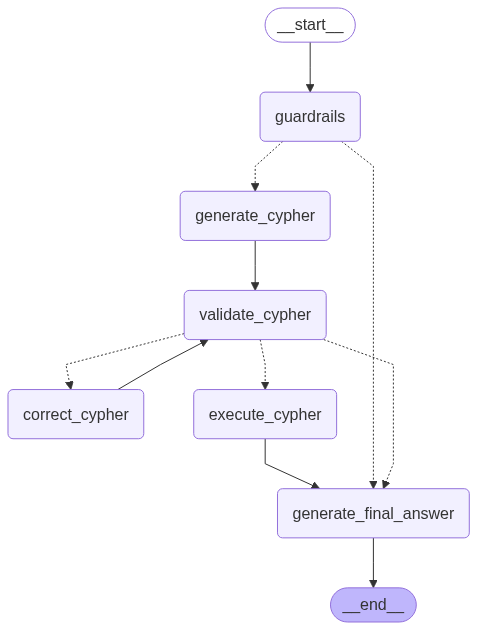

In [46]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph

langgraph = StateGraph(OverallState, input=InputState, output=OutputState)
langgraph.add_node(guardrails)
langgraph.add_node(generate_cypher)
langgraph.add_node(validate_cypher)
langgraph.add_node(correct_cypher)
langgraph.add_node(execute_cypher)
langgraph.add_node(generate_final_answer)

langgraph.add_edge(START, "guardrails")
langgraph.add_conditional_edges(
    "guardrails",
    guardrails_condition,
)
langgraph.add_edge("generate_cypher", "validate_cypher")
langgraph.add_conditional_edges(
    "validate_cypher",
    validate_cypher_condition,
)
langgraph.add_edge("execute_cypher", "generate_final_answer")
langgraph.add_edge("correct_cypher", "validate_cypher")
langgraph.add_edge("generate_final_answer", END)

langgraph = langgraph.compile()

# View
display(Image(langgraph.get_graph().draw_mermaid_png()))

In [47]:
langgraph.invoke({"question": "What's the weather in Spain?"})

{'answer': 'I cannot answer this question as it is not about movies or their cast.',
 'steps': ['guardrail', 'generate_final_answer']}

In [48]:
langgraph.invoke({"question": "What was the cast of the Casino?"})

{'answer': 'The cast of Casino was Robert De Niro, Joe Pesci, Sharon Stone, and James Woods.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'execute_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]-(a:Person) RETURN a.name"}